# Analysis

In [136]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from preprocessing import preprocessing, merge_data
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

## Variables

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [105]:
# Load datasets
store = pd.read_csv('data/raw/store.csv')
train = pd.read_csv('data/raw/train.csv', low_memory=False)
test = pd.read_csv('data/raw/test.csv')

## Explore

### Store data

In [106]:
store.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [107]:
store.shape

(1115, 10)

In [108]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [109]:
# Proportion of NaN among the features
store.isna().sum() / store.shape[0]

Store                        0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002691
CompetitionOpenSinceMonth    0.317489
CompetitionOpenSinceYear     0.317489
Promo2                       0.000000
Promo2SinceWeek              0.487892
Promo2SinceYear              0.487892
PromoInterval                0.487892
dtype: float64

In [110]:
store.nunique()

Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           654
CompetitionOpenSinceMonth      12
CompetitionOpenSinceYear       23
Promo2                          2
Promo2SinceWeek                24
Promo2SinceYear                 7
PromoInterval                   3
dtype: int64

This dataset contains $1115$ rows, one for each store. Therefore, the `Store` colums is a primary key of this table.

In [111]:
store.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.00000,1115,1115,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.00000,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.00000,NaN,NaN,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,NaN
25%,279.50000,NaN,NaN,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000,NaN
50%,558.00000,NaN,NaN,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000,NaN
75%,836.50000,NaN,NaN,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000,NaN


### Sales data

In [112]:
train.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [113]:
train.shape

(1017209, 9)

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [115]:
train.isna().sum() / train.shape[0]

Store            0.0
DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

In [116]:
train.nunique()

Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64

In [117]:
train.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,2014-06-12,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,986159,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00


## Analysis
### Store data

In [118]:
train, store = preprocessing(train, store)

In [119]:
store.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0.0
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,2.0
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,2.0


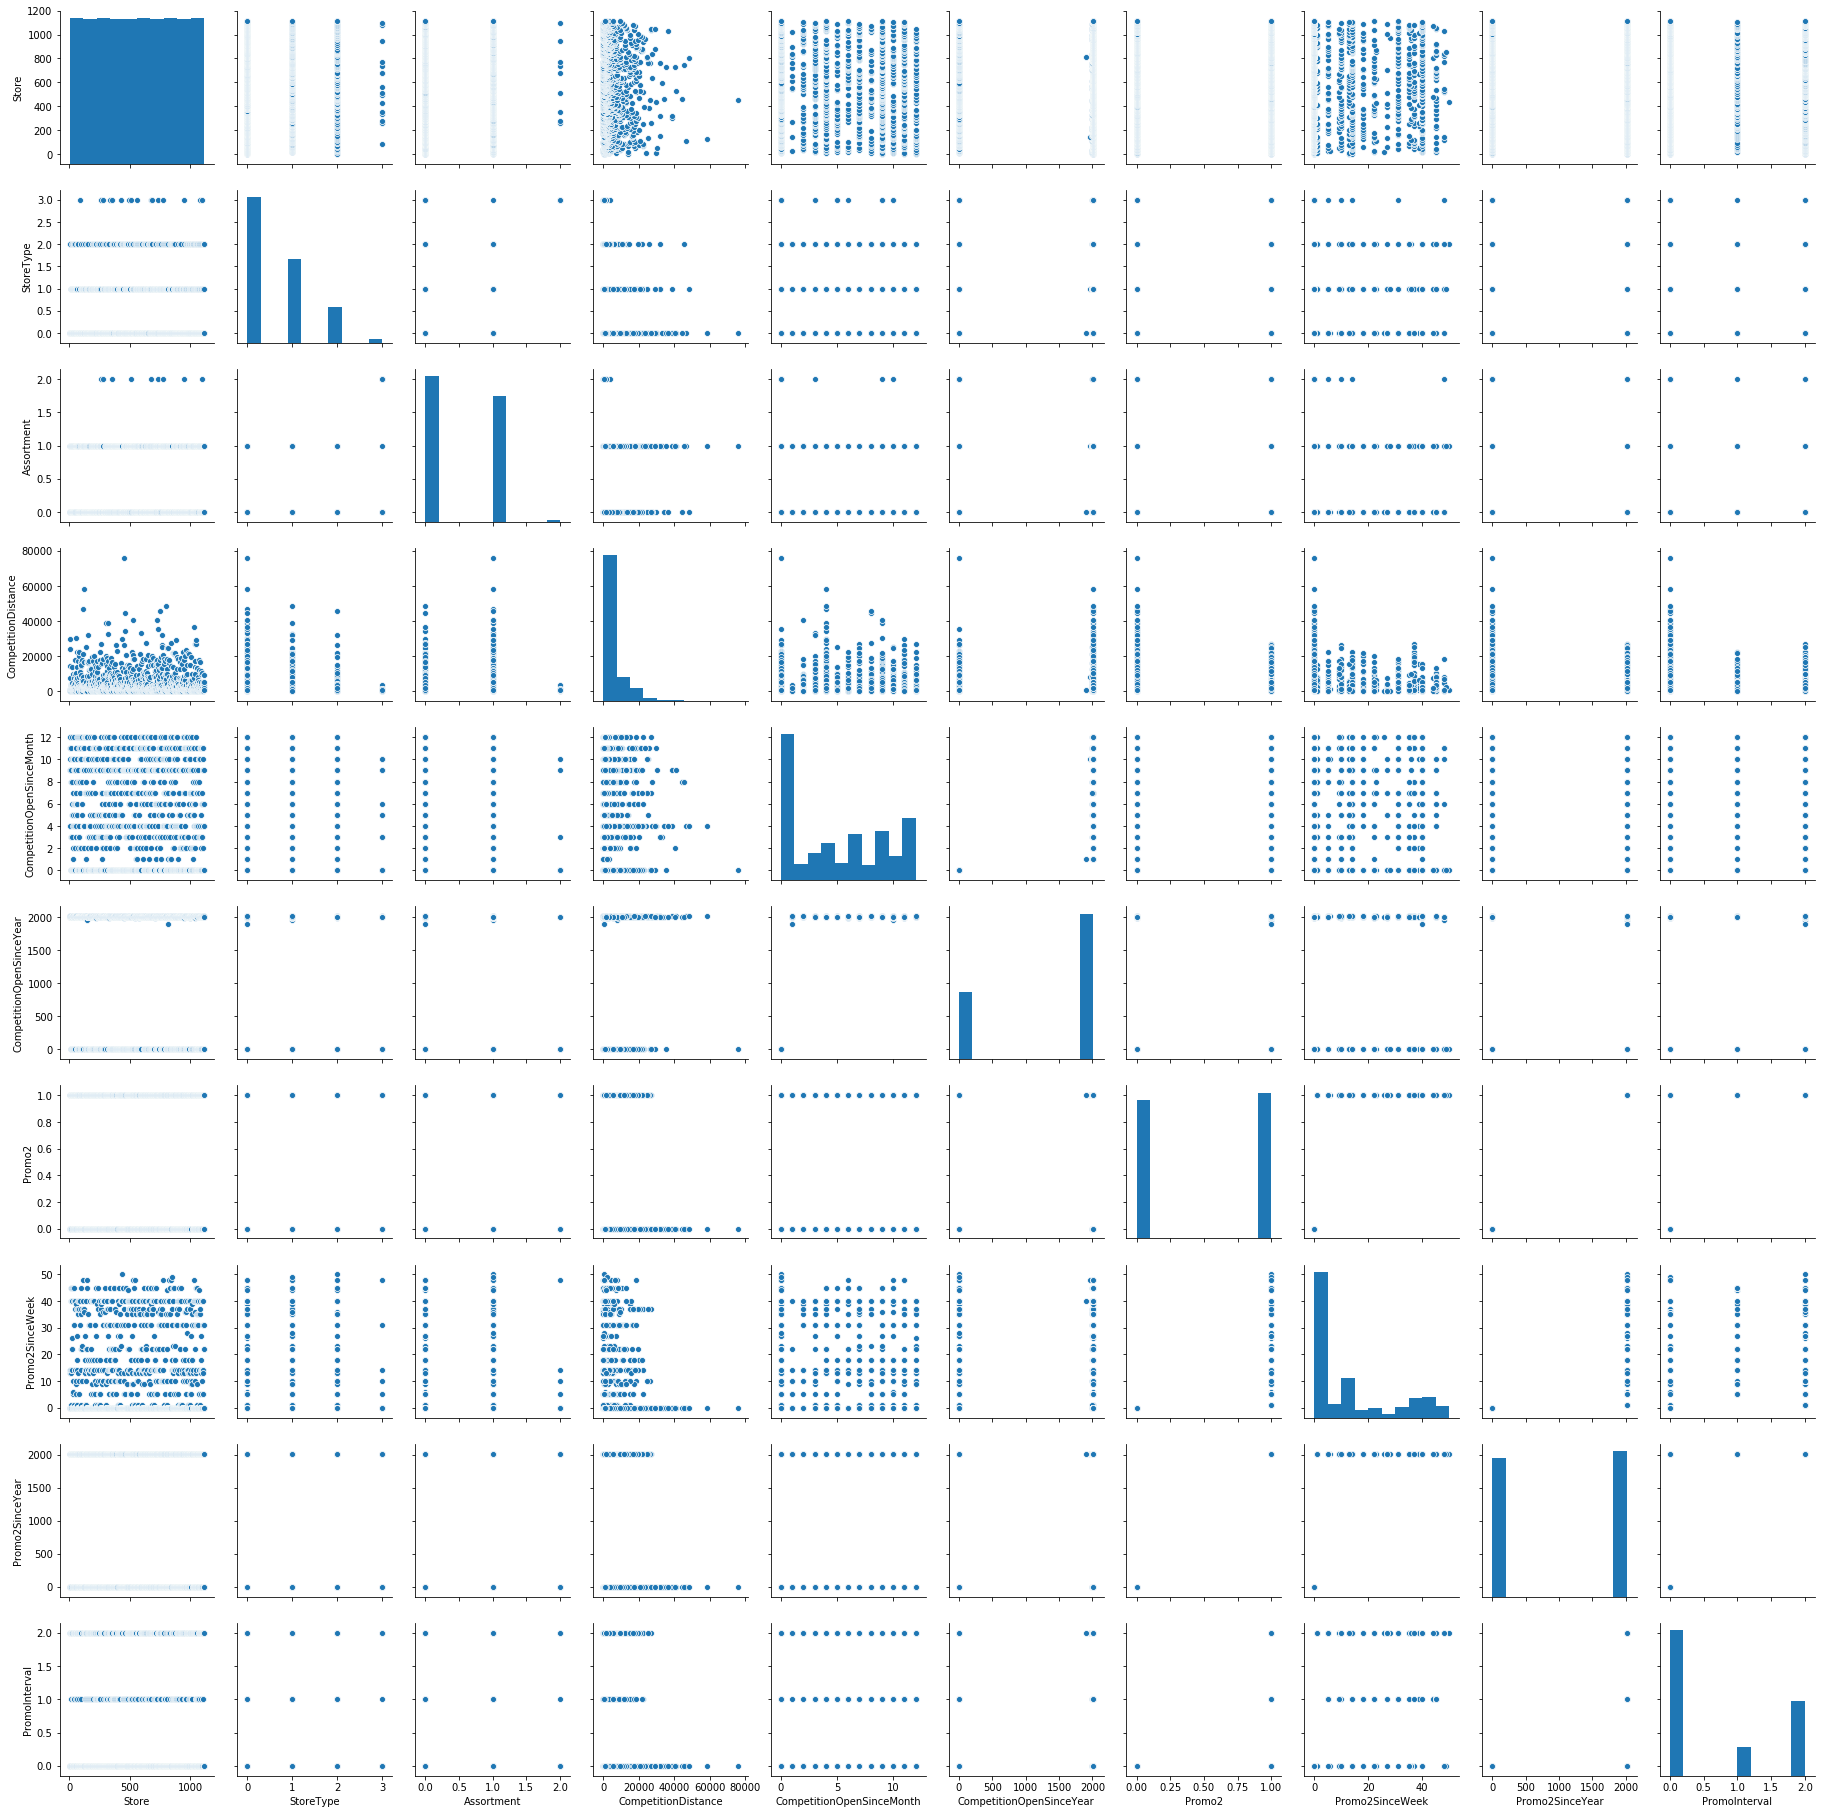

In [19]:
sns.pairplot(store) #, hue='StoreType')

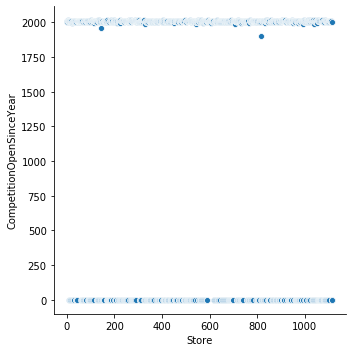

In [121]:
sns.relplot(x='Store', y='CompetitionOpenSinceYear', data=store)

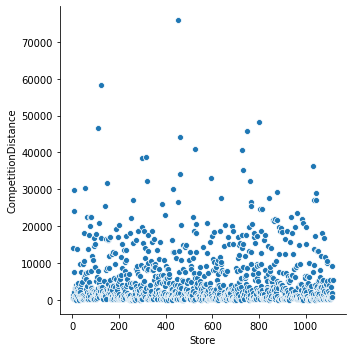

In [120]:
sns.relplot(x='Store', y='CompetitionDistance',
            data=store)

### Sales data

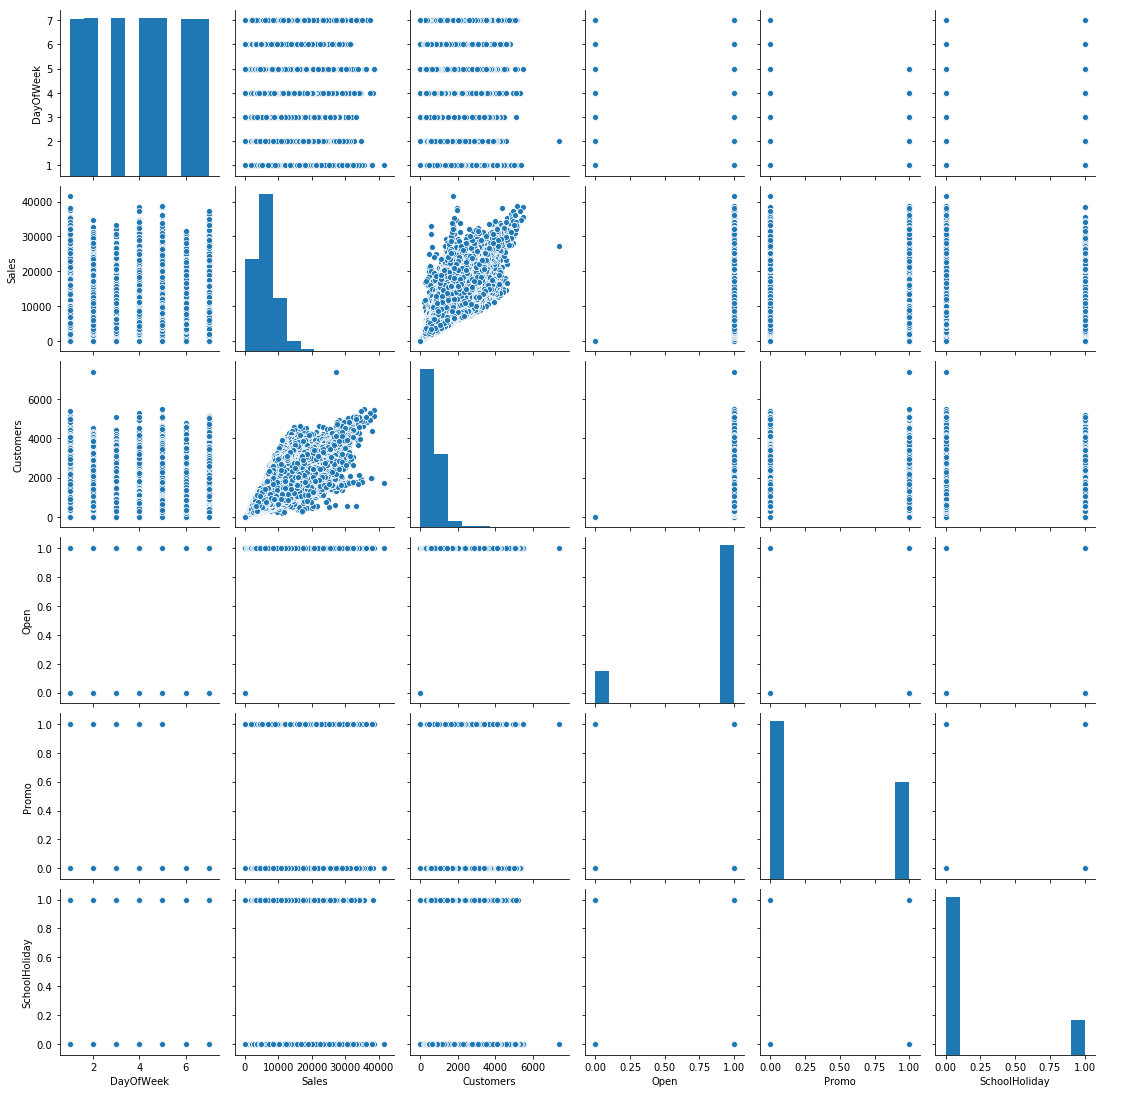

In [20]:
columns = ['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday']
sns.pairplot(train[columns])

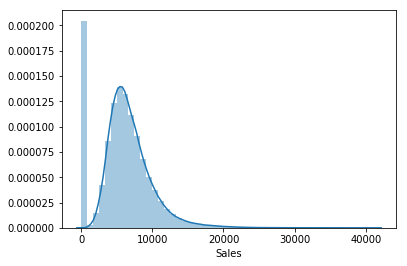

In [22]:
#sns.distplot(train[train['Sales'] != 0]['Sales'])
sns.distplot(train['Sales'])

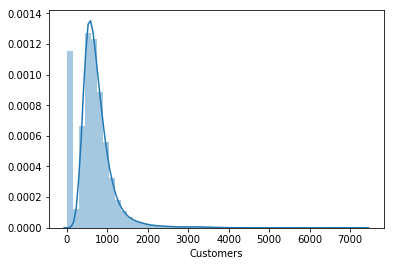

In [23]:
sns.distplot(train['Customers'])

### Merge data

In [122]:
merge_train = merge_data(train, store, remove_outliers=False)

In [123]:
merge_train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0.0
1,2,5,6064,625,1,1,0,1,2015,7,0,0,570.0,11.0,2007.0,1,13.0,2010.0,2.0
2,3,5,8314,821,1,1,0,1,2015,7,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,2.0
3,4,5,13995,1498,1,1,0,1,2015,7,2,1,620.0,9.0,2009.0,0,0.0,0.0,0.0
4,5,5,4822,559,1,1,0,1,2015,7,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0.0


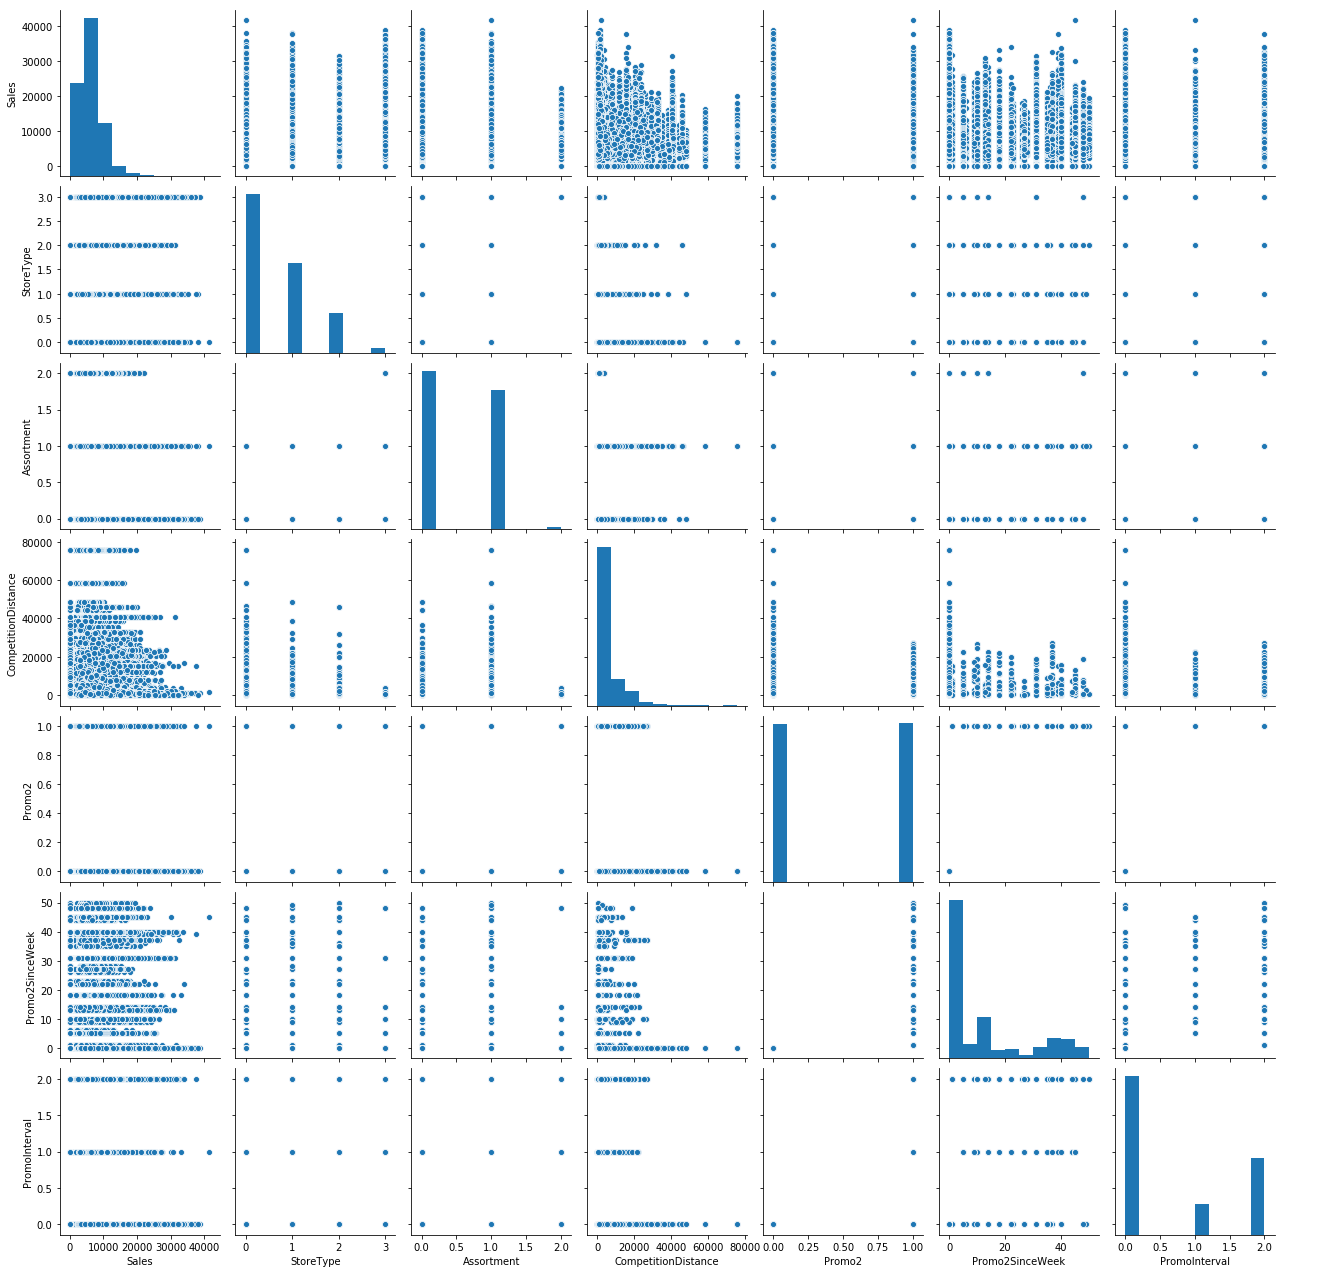

In [26]:
columns_to_plot = ['Sales', 'StoreType', 'Assortment', 'CompetitionDistance', 
                   'Promo2', 'Promo2SinceWeek', 'PromoInterval']
sns.pairplot(merge_train[columns_to_plot])

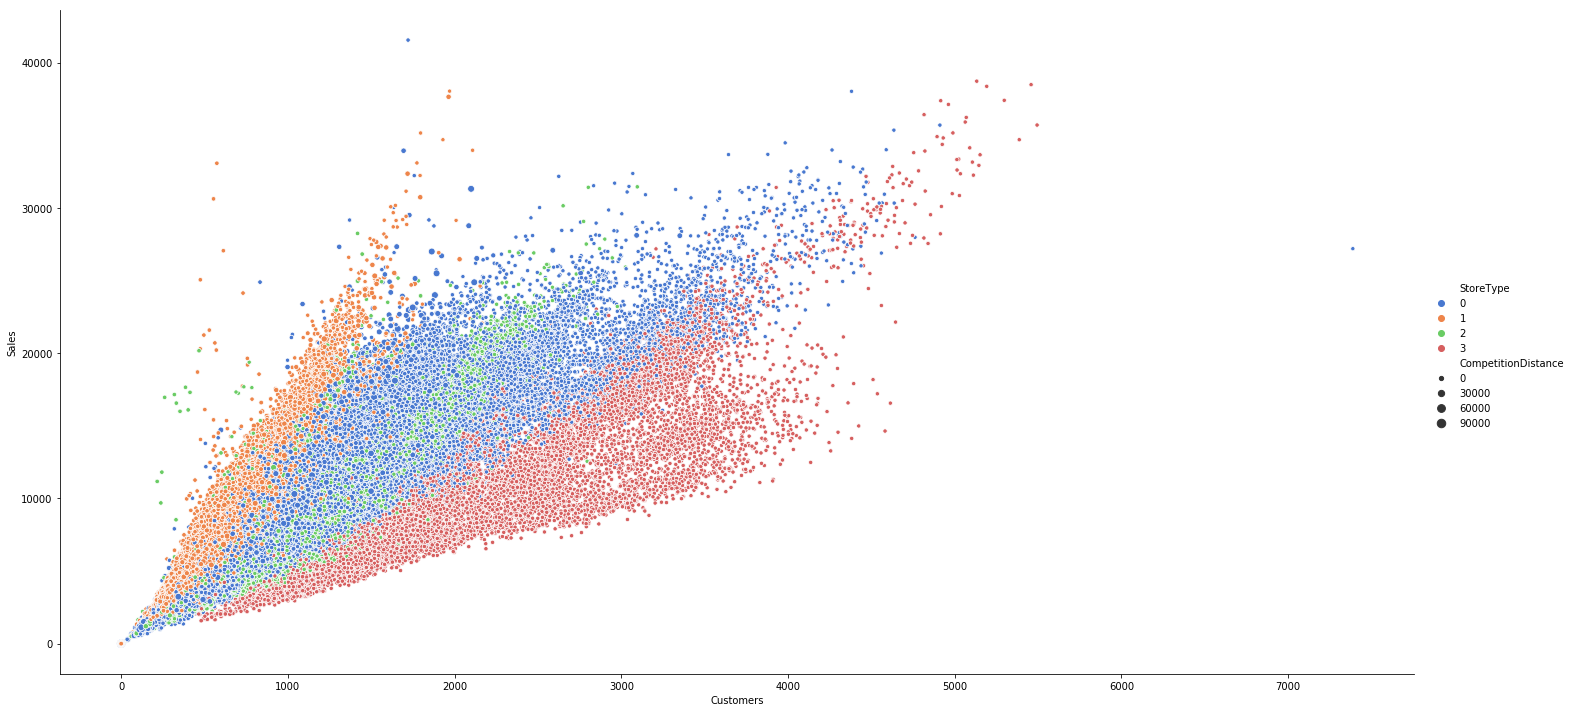

In [27]:
# Plot influence of the store type and number of customers
sns.relplot(x='Customers', y='Sales', hue='StoreType', size='CompetitionDistance',
            palette='muted', height=10, aspect=2,
            data=merge_train)

## Delete outliers

In [124]:
merge_train = merge_data(train, store, remove_outliers=True)

## Feature selection

In [125]:
merge_train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'year', 'month', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [126]:
column_target = ['Sales']
features_to_drop = [] + column_target
X = merge_train.drop(columns=features_to_drop)
X.reset_index(drop=True, inplace=True)
y = merge_train[column_target]
y.reset_index(drop=True, inplace=True)
X.head(3)

,Store,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,555,1,1,0,1,2015,7,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0.0
1,2,5,625,1,1,0,1,2015,7,0,0,570.0,11.0,2007.0,1,13.0,2010.0,2.0
2,4,5,1498,1,1,0,1,2015,7,2,1,620.0,9.0,2009.0,0,0.0,0.0,0.0


In [139]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.9, random_state=42)

### Univariate selection

In [140]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  # print 10 best features

                        Specs         Score
2                   Customers  1.583014e+07
16            Promo2SinceYear  1.264395e+07
11        CompetitionDistance  1.211165e+07
0                       Store  2.073889e+06
15            Promo2SinceWeek  2.249351e+05
1                   DayOfWeek  2.359015e+04
8                       month  2.248041e+04
12  CompetitionOpenSinceMonth  1.688956e+04
9                   StoreType  1.570281e+04
17              PromoInterval  1.337415e+04


### Feature importance¶

In [141]:
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

C:\Users\Benjamin\Anaconda3\envs\datacamp\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


TypeError: __init__() missing 1 required positional argument: 'dtype'

### Correlation matrix

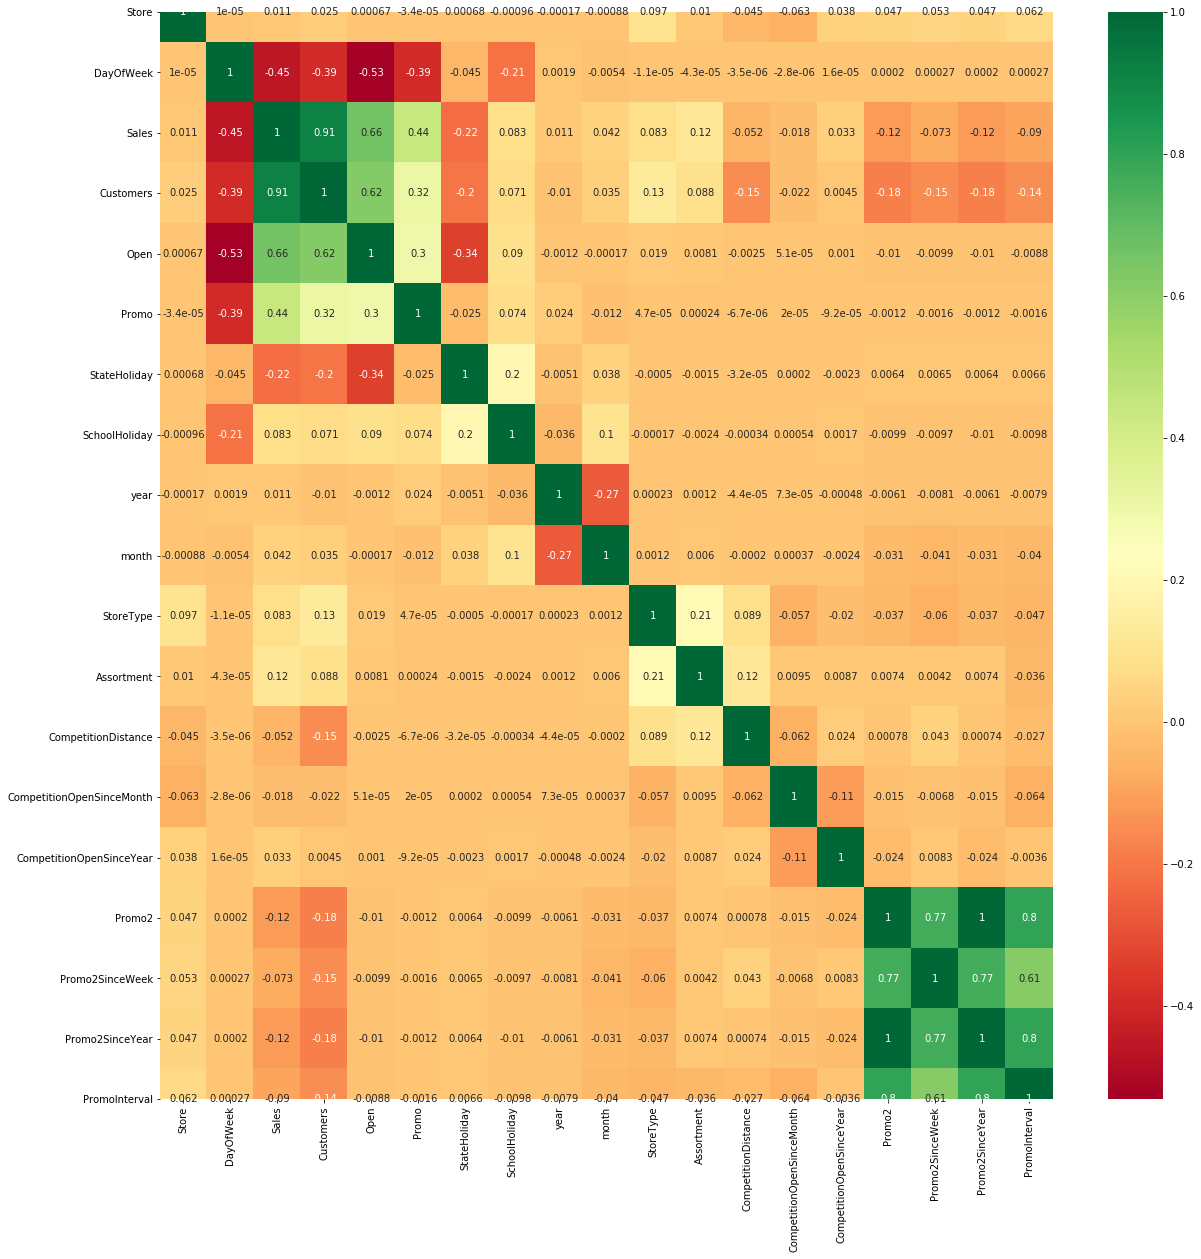

In [145]:
#get correlations of each features in dataset
corrmat = merge_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(merge_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")